In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', None)


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [18]:
merged_data = pd.read_parquet('E:/mmar_project_data/data/processed/merged_loan_data.parquet')
merged_data['year'] = merged_data['first_observation'].astype(str).str[:4]
#merged_data = merged_data[merged_data['year'].astype(int) in [2018]]

# Filter for just Illinois state

merged_data = merged_data[merged_data['year'] == '2018']

In [3]:
# Function to download information from the FRED API

import requests
import os
from dotenv import load_dotenv

def get_fred_data(series_id):
    """
    Retrieves economic data from the FRED API in JSON format
    
    Args:
        series_id (str): The FRED series ID to retrieve
        
    Returns:
        dict: JSON response from the FRED API containing the requested data
    """
    # Load API key from environment variables
    load_dotenv()
    api_key = os.getenv('FRED_API_KEY')
    
    # Construct the API URL
    base_url = "https://api.stlouisfed.org/geofred/regional/data"
    params = {
        'series_group': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'region_type': 'msa',
        'units': 'Percent',
        'frequency': 'm',
        'start_date': '2010-01-01',
        'season': 'NSA'
    }
    
    # Make the API request
    response = requests.get(base_url, params=params)
    
    # Check if request was successful
    if response.status_code == 200:
        data = response.json()
        # Convert JSON data to pandas DataFrame
        #df = pd.DataFrame(data['meta']['data'])
        return data
    else:
        raise Exception(f"Failed to retrieve data: {response.status_code}")

# 1224 unemployment rate

# 155206, Units private housing autorization
# 246342, Units, housing inventory

fred_data = [get_fred_data(x)  for x in ['1224', '155206', '246342']]

In [4]:
# Function to process the FRED data

def process_fred_data(fred_data, df_columns = ['date', 'MSA', 'Code', 'value', 'series_id']):
    rows = []
    for period in fred_data['meta']['data'].keys():
        for row in fred_data['meta']['data'][period]:
            rows.append([period] + list(row.values()))
    return pd.DataFrame(rows, columns=df_columns)

In [5]:
fred_data_df = [process_fred_data(fred) for fred in fred_data]

fred_unemployment_rate = fred_data_df[0] # 1224 unemployment rate
fred_private_housing_autorization = fred_data_df[1] # 155206 private housing autorization
fred_housing_inventory = fred_data_df[2] # 246342 housing inventory

fred_unemployment_rate['unemployment_rate'] = fred_unemployment_rate['value'].astype(float)
fred_private_housing_autorization['private_housing_autorization'] = fred_private_housing_autorization['value'].astype(float)
fred_housing_inventory['housing_inventory'] = fred_housing_inventory['value'].astype(float)


fred_merged = pd.merge(fred_unemployment_rate, fred_private_housing_autorization, on=['date', 'MSA', 'Code'], how='inner')
fred_merged = pd.merge(fred_merged, fred_housing_inventory, on=['date', 'MSA', 'Code'], how='inner')


fred_merged = fred_merged[['date', 'MSA', 'Code', 'unemployment_rate', 'private_housing_autorization', 'housing_inventory']]

fred_merged.head()

fred_merged['date_merge'] = pd.to_datetime(fred_merged['date']).dt.strftime('%Y%m').astype(int)

fred_merged.to_parquet('E:/mmar_project_data/data/processed/fred_data.parquet')


In [15]:
fred_housing_inventory


,date,MSA,Code,value,series_id,housing_inventory
0,2016-07-01,"Albemarle, NC",10620,429,ACTLISCOU10620,429.0
1,2016-07-01,"Macomb, IL",31380,208,ACTLISCOU31380,208.0
2,2016-07-01,"Hanford-Corcoran, CA",25260,265,ACTLISCOU25260,265.0
3,2016-07-01,"Meridian, MS",32940,428,ACTLISCOU32940,428.0
4,2016-07-01,"Goldsboro, NC",24140,591,ACTLISCOU24140,591.0
...,...,...,...,...,...,...
91742,2024-11-01,"Mount Sterling, KY",34460,172,ACTLISCOU34460,172.0
91743,2024-11-01,"Big Spring, TX",13700,149,ACTLISCOU13700,149.0
91744,2024-11-01,"Steamboat Springs, CO",44460,177,ACTLISCOU44460,177.0
91745,2024-11-01,"Mount Vernon, IL",34500,53,ACTLISCOU34500,53.0


In [6]:
# First remove any None values before converting to int
merged_data['metropolitan_statistical_area'] = merged_data['metropolitan_statistical_area'].fillna(-1)
merged_data['metropolitan_statistical_area'] = merged_data['metropolitan_statistical_area'].astype(int)

fred_merged['Code'] = fred_merged['Code'].astype(int)


In [10]:
merged_data_final = pd.merge(merged_data, fred_merged, left_on=['metropolitan_statistical_area', 'first_payment_date'], right_on=['Code', 'date_merge'], how='left')


In [19]:
merged_data_final

,credit_score,first_payment_date,first_time_homebuyer_flag,maturity_date,metropolitan_statistical_area,mortgage_insurance_percentage,number_of_units,occupancy_status,original_cltv,original_dti_ratio,original_upb,original_ltv,original_interest_rate,channel,ppm_flag,amortization_type,property_state,property_type,postal_code,loan_sequence_number,loan_purpose,original_loan_term,number_of_borrowers,seller_name,servicer_name,super_conforming_flag,pre_harp_loan_sequence_number,program_indicator,harp_indicator,property_valuation_method,interest_only_indicator,mortgage_insurance_cancellation_indicator,worst_delinquency_status,first_observation,last_observation,final_zero_balance_code,defaulted,observation_period_months,month_of_default,defaulted_at_start,year,date,MSA,Code,unemployment_rate,private_housing_autorization,housing_inventory,date_merge
0,720,201103,N,202602,16984,0,1,P,87.0,46.0,250000.0,78.0,3.625,R,N,FRM,IL,SF,60400,F11Q10000001,N,180,1,Other sellers,Other servicers,None,None,9,None,9,N,9,2.0,201102,202406,NaN,0,160,<NA>,0,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,795,201103,N,202602,30460,0,1,P,69.0,32.0,168000.0,69.0,4.375,R,N,FRM,KY,SF,40300,F11Q10000002,N,180,2,Other sellers,Other servicers,None,None,9,None,9,N,9,0.0,201102,201204,1.0,0,14,<NA>,0,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,770,201103,N,202602,-1,0,1,P,75.0,37.0,171000.0,75.0,3.625,R,N,FRM,MN,SF,55700,F11Q10000003,N,180,2,Other sellers,Other servicers,None,None,9,None,9,N,9,0.0,201102,201707,1.0,0,77,<NA>,0,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,785,201103,N,202602,16974,0,1,P,71.0,999.0,141000.0,71.0,3.500,R,N,FRM,IL,SF,60400,F11Q10000004,N,180,1,Other sellers,Other servicers,None,F09Q10001946,9,Y,9,N,9,1.0,201102,202007,1.0,0,113,<NA>,0,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,756,201104,N,204103,16974,0,1,P,103.0,999.0,352000.0,103.0,5.375,R,N,FRM,IL,CO,60600,F11Q10000005,N,360,1,Other sellers,Other servicers,None,F08Q40000273,9,Y,9,N,9,0.0,201103,201502,1.0,0,47,<NA>,0,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196567,680,201201,N,204112,-1,0,1,P,80.0,28.0,96000.0,80.0,4.000,R,N,FRM,MN,SF,55900,F11Q40366858,P,360,2,Other sellers,Other servicers,None,None,9,None,9,N,9,0.0,201112,202101,1.0,0,109,<NA>,0,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196568,802,201201,N,204112,42020,0,1,S,74.0,11.0,307000.0,74.0,3.875,R,N,FRM,CA,PU,93400,F11Q40367964,N,360,1,Other sellers,Other servicers,None,None,9,None,9,N,9,0.0,201112,201710,1.0,0,70,<NA>,0,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196569,791,201201,N,204112,36084,0,1,P,43.0,41.0,242000.0,43.0,4.125,R,N,FRM,CA,SF,94500,F11Q40367967,N,360,2,Other sellers,Other servicers,None,None,9,None,9,N,9,0.0,201112,202406,NaN,0,150,<NA>,0,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196570,729,201201,N,204112,41884,0,1,P,49.0,43.0,262000.0,49.0,4.375,R,N,FRM,CA,PU,94000,F11Q40367968,C,360,2,Other sellers,Other servicers,None,None,9,None,9,N,9,0.0,201112,201208,1.0,0,8,<NA>,0,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Load API key from environment variables
load_dotenv()
api_key = os.getenv('FRED_API_KEY')

# Construct the API URL
base_url = "https://api.stlouisfed.org/geofred/series/group"
params = {
    'series_id': 'APUS37A72610',
    'api_key': api_key,
    'file_type': 'json'
}

# Make the API request
response = requests.get(base_url, params=params)

# Check if request was successful
if response.status_code == 200:
    series_info = response.json()
    print(series_info)
else:
    print(f"Failed to retrieve data: {response.status_code}")


# 155206, Units
# 246342, Units
# 


Failed to retrieve data: 500


In [303]:
# Encode first_time_homebuyer_flag in place
merged_data['first_time_homebuyer_flag'] = (merged_data['first_time_homebuyer_flag'] == 'Y').astype(int)

# Create dummy variables for occupancy_status
occupancy_dummies = pd.get_dummies(merged_data['occupancy_status'], prefix='occupancy')
merged_data = pd.concat([merged_data, occupancy_dummies], axis=1)
merged_data.drop('occupancy_status', axis=1, inplace=True)

# Replace 999 with NA for numeric columns
numeric_columns = merged_data.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_columns:
    # Skip certain columns that shouldn't be modified
    if col not in ['year', 'defaulted', 'first_observation', 'last_observation',
                   'observation_period_months']:
        merged_data[col] = merged_data[col].replace([999, 9999], np.nan)

# Create dummy variables for loan_purpose
loan_purpose_dummies = pd.get_dummies(merged_data['loan_purpose'], prefix='loan_purpose')
merged_data = pd.concat([merged_data, loan_purpose_dummies], axis=1)
merged_data.drop('loan_purpose', axis=1, inplace=True)

# Create dummy for number of borrowers (1 if 2 borrowers, 0 otherwise)
merged_data['more_than_one_borrower'] = (merged_data['number_of_borrowers'] == 2).astype(int)
# Calculate months since first payment for defaulted loans

# Convert dates to datetime, handling NAs

merged_data['month_of_default'] = pd.to_datetime(merged_data['month_of_default'], format='%Y%m', errors='coerce')

# Calculate months difference, which will be NA for non-defaulted loans
merged_data['month_of_default'] = (merged_data['month_of_default'] - 
                                  pd.to_datetime(merged_data['first_payment_date'], format='%Y%m'))

# Convert timedelta to months for easier comparison
merged_data['months_to_default'] = merged_data['month_of_default'].dt.total_seconds()/(60*60*24*30.44)

# Create default indicators at different time horizons
merged_data['defaulted_at_12'] = ((merged_data['months_to_default'] <= 12) & 
                                 (merged_data['months_to_default'].notna())).astype(int)
merged_data['defaulted_at_24'] = ((merged_data['months_to_default'] <= 24) & 
                                 (merged_data['months_to_default'].notna())).astype(int)
merged_data['defaulted_at_36'] = ((merged_data['months_to_default'] <= 36) & 
                                 (merged_data['months_to_default'].notna())).astype(int)


merged_data.head()

,credit_score,first_payment_date,first_time_homebuyer_flag,maturity_date,metropolitan_statistical_area,mortgage_insurance_percentage,number_of_units,original_cltv,original_dti_ratio,original_upb,original_ltv,original_interest_rate,channel,ppm_flag,amortization_type,property_state,property_type,postal_code,loan_sequence_number,original_loan_term,number_of_borrowers,seller_name,servicer_name,super_conforming_flag,pre_harp_loan_sequence_number,program_indicator,harp_indicator,property_valuation_method,interest_only_indicator,mortgage_insurance_cancellation_indicator,worst_delinquency_status,first_observation,last_observation,final_zero_balance_code,defaulted,observation_period_months,month_of_default,defaulted_at_start,year,occupancy_I,occupancy_P,occupancy_S,loan_purpose_C,loan_purpose_N,loan_purpose_P,more_than_two_borrowers,months_to_default,defaulted_at_12,defaulted_at_24,defaulted_at_36
0,720,201103,0,202602,16984,0,1,87.0,46.0,250000.0,78.0,3.625,R,N,FRM,IL,SF,60400,F11Q10000001,180,1,Other sellers,Other servicers,None,None,9,None,9,N,9,2.0,201102,202406,NaN,0,160,NaT,0,2011,0,1,0,0,1,0,0,NaN,0,0,0
3,785,201103,0,202602,16974,0,1,71.0,NaN,141000.0,71.0,3.500,R,N,FRM,IL,SF,60400,F11Q10000004,180,1,Other sellers,Other servicers,None,F09Q10001946,9,Y,9,N,9,1.0,201102,202007,1.0,0,113,NaT,0,2011,0,1,0,0,1,0,0,NaN,0,0,0
4,756,201104,0,204103,16974,0,1,103.0,NaN,352000.0,103.0,5.375,R,N,FRM,IL,CO,60600,F11Q10000005,360,1,Other sellers,Other servicers,None,F08Q40000273,9,Y,9,N,9,0.0,201103,201502,1.0,0,47,NaT,0,2011,0,1,0,0,1,0,0,NaN,0,0,0
10,735,201103,0,202602,19340,0,1,53.0,42.0,166000.0,53.0,4.375,R,N,FRM,IL,SF,61200,F11Q10000013,180,2,Other sellers,U.S. BANK N.A.,None,None,9,None,9,N,9,0.0,201102,201303,1.0,0,25,NaT,0,2011,0,1,0,0,1,0,1,NaN,0,0,0
14,784,201103,0,202602,14010,0,1,91.0,40.0,251000.0,73.0,4.000,R,N,FRM,IL,SF,61700,F11Q10000017,180,1,Other sellers,Other servicers,None,None,9,None,9,N,9,0.0,201102,201309,1.0,0,31,NaT,0,2011,0,1,0,0,1,0,0,NaN,0,0,0


In [304]:
X_regressors = [
    'credit_score',  # Credit score is a key risk indicator
    'original_dti_ratio',
    'original_cltv',
    'original_interest_rate',
    'first_time_homebuyer_flag', # Important borrower characteristic
    'occupancy_P', 'occupancy_S', # Property occupancy type
    'loan_purpose_N', 'loan_purpose_P' # Loan purpose
]

D = 'more_than_one_borrower'
y_var = 'defaulted'
cluster_vars = 'metropolitan_statistical_area'
fixed_effect_vars = 'first_payment_date'

key_columns = X_regressors + [y_var] + [cluster_vars] + [fixed_effect_vars] + [D]

data_key_columns = merged_data[key_columns]

# Remove rows with any NA values from key columns
data_key_columns.dropna(inplace=True)

data_key_columns.describe()


C:\Users\arovi\AppData\Local\Temp\ipykernel_26736\3971371825.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_key_columns.dropna(inplace=True)


,credit_score,original_dti_ratio,original_cltv,original_interest_rate,first_time_homebuyer_flag,occupancy_P,occupancy_S,loan_purpose_N,loan_purpose_P,defaulted,first_payment_date,more_than_two_borrowers
count,330098.0,330098.000000,330098.000000,330098.000000,330098.000000,330098.000000,330098.000000,330098.000000,330098.000000,330098.000000,330098.0,330098.000000
mean,759.093415,32.655251,73.451451,3.840033,0.163936,0.934498,0.010252,0.407579,0.397118,0.027346,201376.580652,0.567341
std,41.863032,9.585449,16.144871,0.572447,0.370218,0.247410,0.100730,0.491385,0.489302,0.163091,173.070493,0.495445
min,517.0,1.000000,6.000000,2.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,201102.0,0.000000
25%,732.0,25.000000,65.000000,3.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,201210.0,0.000000
50%,770.0,33.000000,78.000000,3.875000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,201312.0,1.000000
75%,792.0,41.000000,80.000000,4.250000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,201510.0,1.000000
max,832.0,65.000000,132.000000,6.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,201701.0,1.000000


In [327]:
output_dir


WindowsPath('final_project/plots')

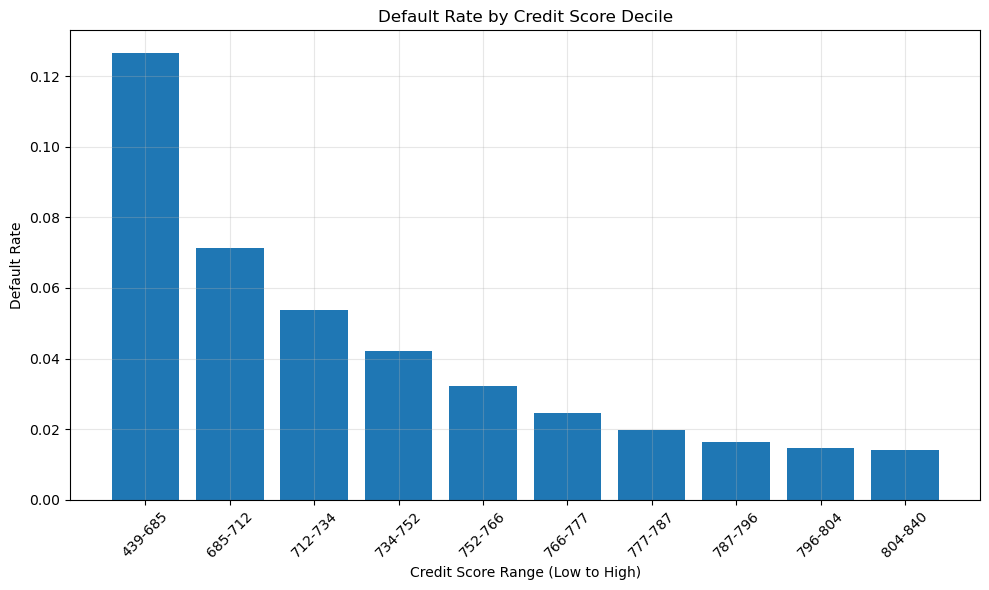

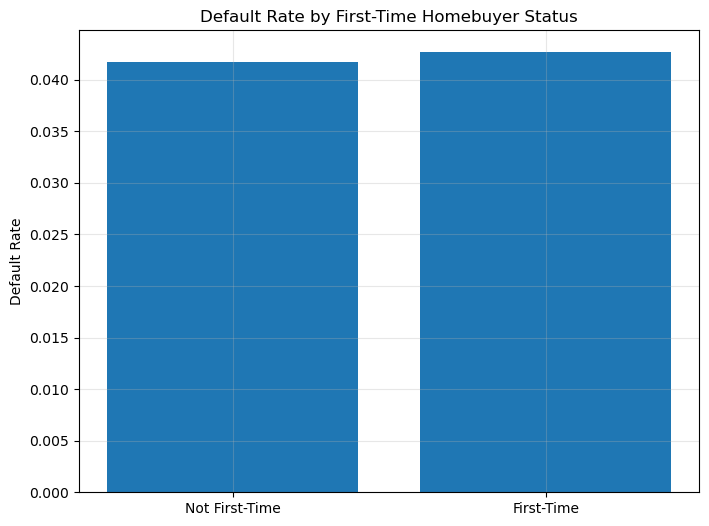

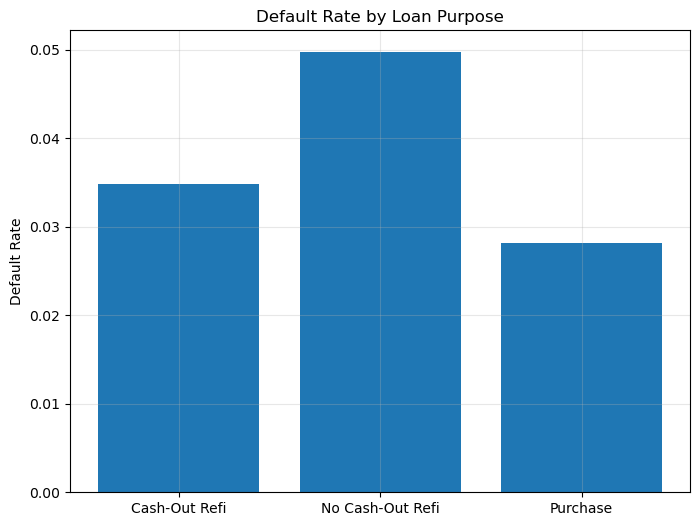

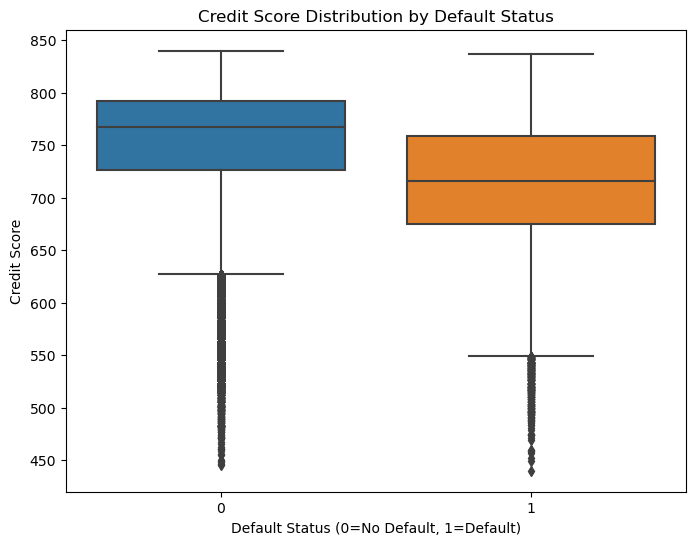

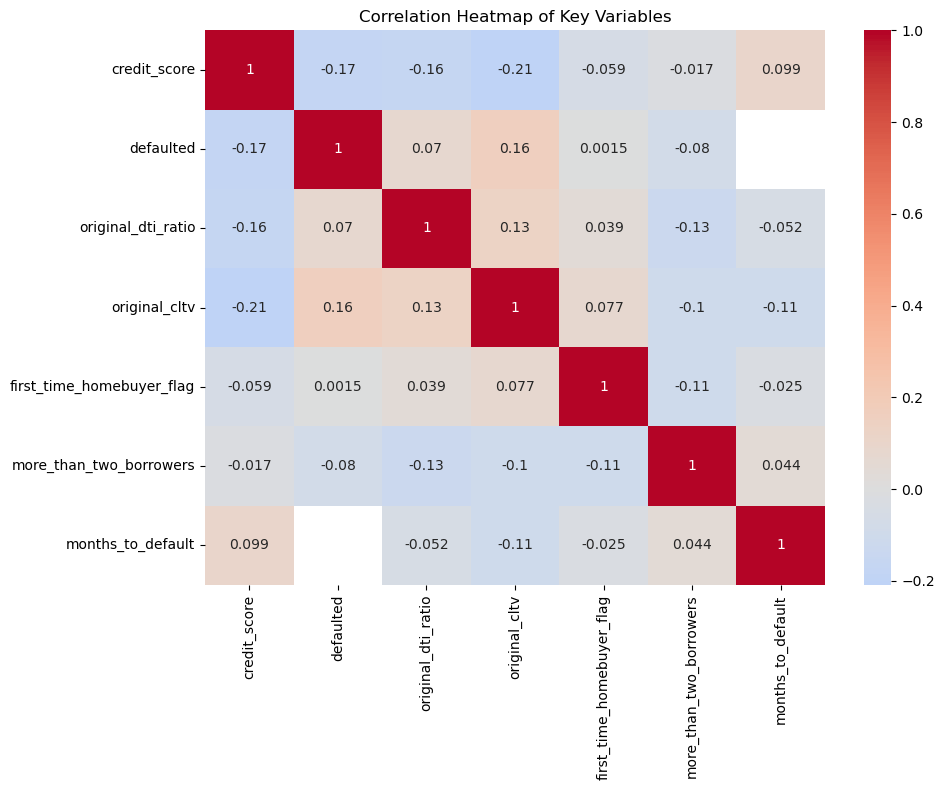

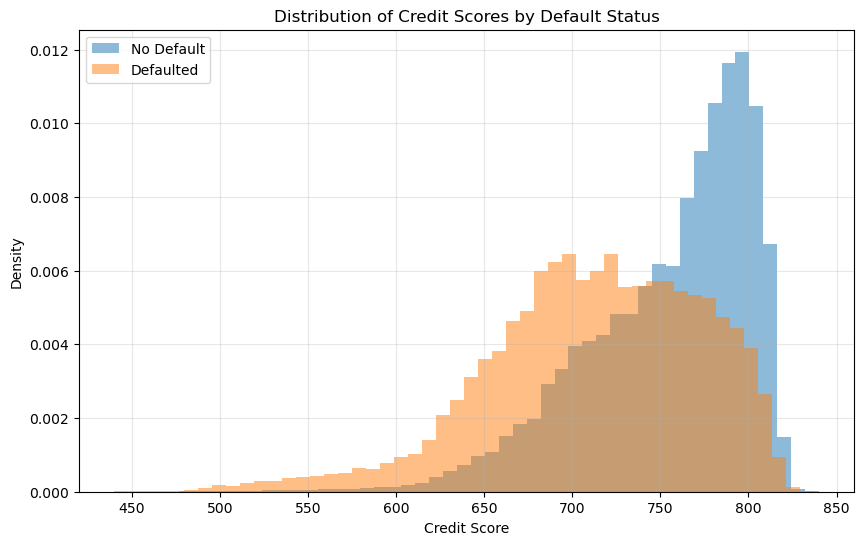

OSError: [WinError 433] Se ha especificado un dispositivo que no existe: 'final_project\\plots'

In [334]:
# Create several visualizations to explore the data

# 1. Default Rate by Credit Score Range
plt.figure(figsize=(10, 6))
merged_data['credit_score_bin'] = pd.qcut(merged_data['credit_score'], q=10)
default_by_credit = merged_data.groupby('credit_score_bin')['defaulted'].mean()

plt.bar(range(len(default_by_credit)), default_by_credit.values)
plt.title('Default Rate by Credit Score Decile')
plt.xlabel('Credit Score Range (Low to High)')
plt.ylabel('Default Rate')
plt.xticks(range(len(default_by_credit)), [f'{int(x.left)}-{int(x.right)}' for x in default_by_credit.index], rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Default Rate by First-Time Homebuyer Status
plt.figure(figsize=(8, 6))
default_by_firsttime = merged_data.groupby('first_time_homebuyer_flag')['defaulted'].mean()

plt.bar(['Not First-Time', 'First-Time'], default_by_firsttime.values)
plt.title('Default Rate by First-Time Homebuyer Status')
plt.ylabel('Default Rate')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Default Rate by Loan Purpose
plt.figure(figsize=(8, 6))
default_by_purpose = merged_data[['defaulted', 'loan_purpose_C', 'loan_purpose_N', 'loan_purpose_P']].groupby(
    [col for col in ['loan_purpose_C', 'loan_purpose_N', 'loan_purpose_P'] if merged_data[col].sum() > 0]
).mean()['defaulted']

plt.bar(['Cash-Out Refi', 'No Cash-Out Refi', 'Purchase'][:len(default_by_purpose)], default_by_purpose.values)
plt.title('Default Rate by Loan Purpose')
plt.ylabel('Default Rate')
plt.grid(True, alpha=0.3)
plt.show()

# 4. Box Plot of Credit Scores by Default Status
plt.figure(figsize=(8, 6))
sns.boxplot(x='defaulted', y='credit_score', data=merged_data[['defaulted', 'credit_score']].dropna())
plt.title('Credit Score Distribution by Default Status')
plt.xlabel('Default Status (0=No Default, 1=Default)')
plt.ylabel('Credit Score')
plt.show()

# 5. Correlation Heatmap of Numeric Variables
numeric_cols = ['credit_score', 'defaulted', 'original_dti_ratio', 'original_cltv',
                'first_time_homebuyer_flag', 'more_than_one_borrower', 'months_to_default']
correlation_matrix = merged_data[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Key Variables')
plt.tight_layout()
plt.show()

# 6. Histogram of Credit Scores by Default Status
plt.figure(figsize=(10, 6))

# Plot histograms for defaulted and non-defaulted loans
plt.hist(merged_data[merged_data['defaulted']==0]['credit_score'].dropna(), 
         bins=50, alpha=0.5, label='No Default', density=True)
plt.hist(merged_data[merged_data['defaulted']==1]['credit_score'].dropna(), 
         bins=50, alpha=0.5, label='Defaulted', density=True)

plt.title('Distribution of Credit Scores by Default Status')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


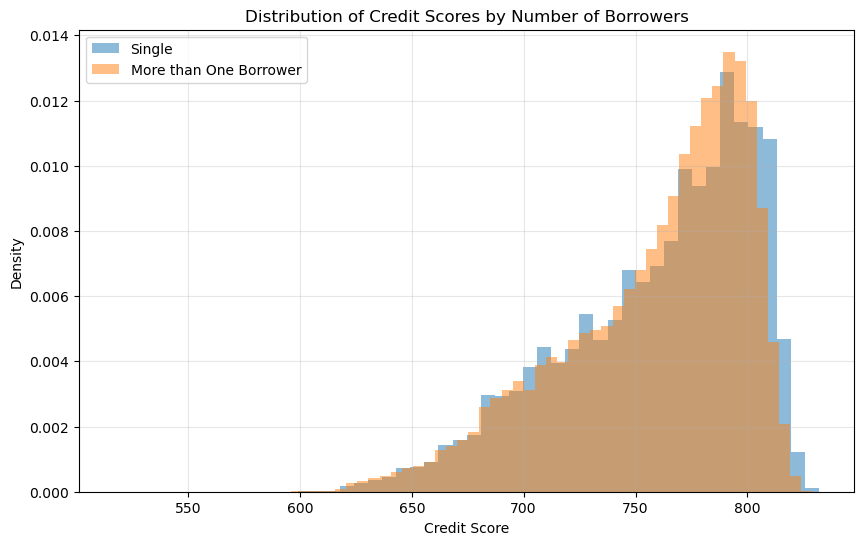

In [335]:
# 7. Histogram of Credit Scores by Number of Debtors
plt.figure(figsize=(10, 6))

# Plot histograms for single vs multiple debtors
plt.hist(data_key_columns[data_key_columns['more_than_one_borrower']==0]['credit_score'], 
         bins=50, alpha=0.5, label='Single', density=True)
plt.hist(data_key_columns[data_key_columns['more_than_one_borrower']==1]['credit_score'], 
         bins=50, alpha=0.5, label='More than One Borrower', density=True)

plt.title('Distribution of Credit Scores by Number of Borrowers')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()




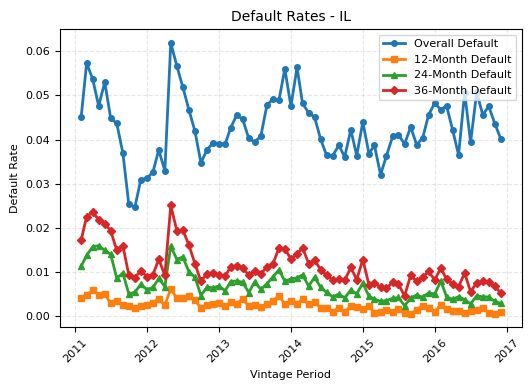

In [307]:
# Calculate default rates by year and state for different default periods
merged_data['first_observation'] = pd.to_datetime(merged_data['first_observation'], format='%Y%m')

# Calculate default rates for each period
default_rates = merged_data.groupby(['first_observation', 'property_state']).agg({
    'defaulted': 'mean',
    'defaulted_at_12': 'mean', 
    'defaulted_at_24': 'mean',
    'defaulted_at_36': 'mean'
}).reset_index()

# Get unique states
states = sorted(merged_data['property_state'].unique())

# Calculate number of rows and columns for subplot grid
n_states = len(states)
n_cols = 3  # You can adjust this
n_rows = (n_states + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

# Create line plots for each state
for idx, state in enumerate(states):
    state_data = default_rates[default_rates['property_state'] == state]
    
    axes[idx].plot(state_data['first_observation'], state_data['defaulted'], 
                  marker='o', linewidth=2, markersize=4, label='Overall Default')
    axes[idx].plot(state_data['first_observation'], state_data['defaulted_at_12'], 
                  marker='s', linewidth=2, markersize=4, label='12-Month Default')
    axes[idx].plot(state_data['first_observation'], state_data['defaulted_at_24'], 
                  marker='^', linewidth=2, markersize=4, label='24-Month Default')
    axes[idx].plot(state_data['first_observation'], state_data['defaulted_at_36'], 
                  marker='D', linewidth=2, markersize=4, label='36-Month Default')
    
    axes[idx].set_title(f'Default Rates - {state}', fontsize=10)
    axes[idx].set_xlabel('Vintage Period', fontsize=8)
    axes[idx].set_ylabel('Default Rate', fontsize=8)
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].tick_params(axis='both', labelsize=8)
    axes[idx].tick_params(axis='x', rotation=45)
    
    if idx == 0:  # Only show legend for first plot
        axes[idx].legend(fontsize=8)

# Remove empty subplots if any
for idx in range(len(states), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('figures/default_rates_by_state.png', dpi=300, bbox_inches='tight')


In [308]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf

def dml(X, D, y, modely, modeld, *, nfolds, classifier=False, cluster=None, fixed_effects=None):
    '''
    DML for the Partially Linear Model setting with cross-fitting, clustering, and fixed effects

    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely: the ML model for predicting the outcome y
    modeld: the ML model for predicting the treatment D
    nfolds: the number of folds in cross-fitting
    classifier: bool, whether the modeld is a classifier or a regressor
    cluster: array-like, cluster indices for clustered standard errors (optional)
    fixed_effects: dict, keys are names of fixed effects, values are arrays of categories (optional)
                  example: {'state': state_array, 'year': year_array}

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the treatment D
    resy: the outcome residuals
    resD: the treatment residuals
    epsilon: the final residual-on-residual OLS regression residual
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)
    yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1)
    
    if classifier:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    else:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
    
    resy = y - yhat
    resD = D - Dhat

    # Create dataframe with residuals
    dml_data = pd.concat([
        pd.Series(resy, name='resy'), 
        pd.Series(resD, name='resD')
    ], axis=1)

    # Add fixed effects to the dataframe and formula
    formula = 'resy ~ 1 + resD'
    if fixed_effects is not None:
        for fe_name, fe_values in fixed_effects.items():
            dml_data[fe_name] = fe_values
            formula += f' + C({fe_name})'  # C() tells statsmodels to treat as categorical

    # Add cluster if provided
    if cluster is not None:
        dml_data['cluster'] = cluster
        ols_mod = smf.ols(formula=formula, data=dml_data).fit(
            cov_type='cluster', 
            cov_kwds={'groups': dml_data['cluster']}
        )
    else:
        ols_mod = smf.ols(formula=formula, data=dml_data).fit(cov_type='HC3')

    point = ols_mod.params['resD']  # Note: changed from [1] to ['resD'] due to FE
    stderr = ols_mod.bse['resD']
    epsilon = ols_mod.resid

    return point, stderr, yhat, Dhat, resy, resD, epsilon

In [309]:
def summary(point, stderr, yhat, Dhat, resy, resD, epsilon, X, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point,  # point estimate
                         'stderr': stderr,  # standard error
                         'lower': point - 1.96 * stderr,  # lower end of 95% confidence interval
                         'upper': point + 1.96 * stderr,  # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)),  # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2))  # RMSE of model that predicts treatment D
                         }, index=[name])

Model specification: using DML to predict the treatment effect of having more than 1 lessor

In [310]:
X = sm.add_constant(data_key_columns['more_than_one_borrower'])
y = data_key_columns['defaulted']

# Add fixed effects for metropolitan statistical area
X = pd.concat([X, pd.get_dummies(data_key_columns[fixed_effect_vars], prefix='fe_', drop_first=True)], axis=1)
lm0 = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': data_key_columns[cluster_vars]})
vc0 = lm0.cov_params()

coef = lm0.params['more_than_one_borrower']
std_err = np.sqrt(vc0.loc['more_than_one_borrower', 'more_than_one_borrower'])
print("Baseline Logit:", coef, "(", std_err, ")")

Baseline Logit: -0.021152074665379775 ( 0.00564667292811514 )


With controls:

In [311]:
X = sm.add_constant(data_key_columns[X_regressors + ["more_than_one_borrower"]].astype(float))
y = pd.DataFrame(data_key_columns['defaulted'])

X = pd.concat([X, pd.get_dummies(data_key_columns[fixed_effect_vars], prefix='fe_', drop_first=True)], axis=1)

lmC = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': data_key_columns[cluster_vars]})
vcC = lmC.cov_params()
coef = lmC.params['more_than_one_borrower']
std_err = np.sqrt(vcC.loc['more_than_one_borrower', 'more_than_one_borrower'])
print("Logit with Controls:", coef, "(", std_err, ")")

Logit with Controls: -0.019448391381679087 ( 0.004721465434494075 )


# DML

In [312]:
n_folds = 5;

In [313]:
# OLS No Controls
Y = data_key_columns['defaulted']
D = data_key_columns['more_than_one_borrower']
Z = pd.DataFrame({"Const": np.ones(len(Y))})  # regression on constant

modely = make_pipeline(StandardScaler(), LinearRegression())
modeld = make_pipeline(StandardScaler(), LinearRegression())

# Run DML model with nfolds folds of cross-fitting
result_OLS = dml(Z, D, Y, modely, modeld, nfolds=n_folds, classifier=False, cluster=data_key_columns[cluster_vars].astype(str), fixed_effects={'first_payment_date': data_key_columns['first_payment_date'].astype(str)})
table = summary(*result_OLS, Z, D, y, name='No Controls')
table

,estimate,stderr,lower,upper,rmse y,rmse D
No Controls,-0.021153,0.005646,-0.03222,-0.010086,0.163091,0.495446


In [314]:
# With controls
Z = data_key_columns[X_regressors]

modely = make_pipeline(StandardScaler(), LinearRegression())
modeld = make_pipeline(StandardScaler(), LinearRegression())

# Run DML model with nfolds folds of cross-fitting
result_basic = dml(Z, D, Y, modely, modeld, nfolds=n_folds, classifier=False, cluster=data_key_columns[cluster_vars].astype(str).values, fixed_effects={'first_payment_date': data_key_columns['first_payment_date'].astype(str).values})
table = pd.concat([table, summary(*result_basic, Z, D, y, name='Basic Controls')])
table

,estimate,stderr,lower,upper,rmse y,rmse D
No Controls,-0.021153,0.005646,-0.032220,-0.010086,0.163091,0.495446
Basic Controls,-0.019691,0.004641,-0.028789,-0.010594,0.161482,0.484771


In [315]:
# DML with Random Forests. RFs don't require scaling but we do it for consistency
modely = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=123))
modeld = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=123))

# Run DML model with nfolds folds of cross-fitting (computationally intensive)
result_RF = dml(Z, D, Y, modely, modeld, nfolds=n_folds, classifier=True, cluster=data_key_columns[cluster_vars].astype(str).values, fixed_effects={'first_payment_date': data_key_columns['first_payment_date'].astype(str).values})
table = pd.concat([table, summary(*result_RF, Z, D, y, name='RF')])
table

,estimate,stderr,lower,upper,rmse y,rmse D
No Controls,-0.021153,0.005646,-0.032220,-0.010086,0.163091,0.495446
Basic Controls,-0.019691,0.004641,-0.028789,-0.010594,0.161482,0.484771
RF,-0.018653,0.004813,-0.028086,-0.009219,0.165368,0.483102


In [316]:
# DML with Boosted Trees
modely = make_pipeline(StandardScaler(), GradientBoostingClassifier(max_depth=4, n_iter_no_change=5))
modeld = make_pipeline(StandardScaler(), GradientBoostingClassifier(max_depth=4, n_iter_no_change=5))

# Run DML model with nfolds folds of cross-fitting (computationally intensive)
result_BT = dml(Z, D, Y, modely, modeld, nfolds=n_folds, classifier=True, cluster=data_key_columns[cluster_vars].astype(str).values, fixed_effects={'first_payment_date': data_key_columns['first_payment_date'].astype(str).values})
table = pd.concat([table, summary(*result_BT, Z, D, y, name='Boosted Trees')])
table

,estimate,stderr,lower,upper,rmse y,rmse D
No Controls,-0.021153,0.005646,-0.032220,-0.010086,0.163091,0.495446
Basic Controls,-0.019691,0.004641,-0.028789,-0.010594,0.161482,0.484771
RF,-0.018653,0.004813,-0.028086,-0.009219,0.165368,0.483102
Boosted Trees,-0.019223,0.004948,-0.028922,-0.009524,0.165395,0.478110


In [317]:
# DML with NNs
modely = make_pipeline(StandardScaler(),
                       MLPClassifier(hidden_layer_sizes=(50, 50, 50, 50),
                                    activation='relu',
                                    solver='adam',
                                    alpha=0.0001,
                                    batch_size=200,
                                    learning_rate='constant',
                                    learning_rate_init=0.001,
                                    max_iter=200,
                                    shuffle=True,
                                    random_state=None,
                                    tol=1e-4,
                                    verbose=False,
                                    warm_start=False,
                                    momentum=0.9,
                                    nesterovs_momentum=True,
                                    early_stopping=True,
                                    validation_fraction=0.2,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-08,
                                    n_iter_no_change=10)
                       )
modeld = make_pipeline(StandardScaler(),
                       MLPClassifier(hidden_layer_sizes=(50, 50, 50, 50),
                                    activation='relu',
                                    solver='adam',
                                    alpha=0.0001,
                                    batch_size=200,
                                    learning_rate='constant',
                                    learning_rate_init=0.001,
                                    max_iter=200,
                                    shuffle=True,
                                    random_state=None,
                                    tol=1e-4,
                                    verbose=False,
                                    warm_start=False,
                                    momentum=0.9,
                                    nesterovs_momentum=True,
                                    early_stopping=True,
                                    validation_fraction=0.2,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-08,  
                                    n_iter_no_change=10)
                       )

# Run DML model with nfolds folds of cross-fitting
result_NN = dml(Z, D, Y, modely, modeld, nfolds=n_folds, classifier=True, cluster=data_key_columns[cluster_vars].astype(str).values, fixed_effects={'first_payment_date': data_key_columns['first_payment_date'].astype(str).values})
table = pd.concat([table, summary(*result_NN, Z, D, y, name='Logit NN (Early Stopping)')])
table

,estimate,stderr,lower,upper,rmse y,rmse D
No Controls,-0.021153,0.005646,-0.032220,-0.010086,0.163091,0.495446
Basic Controls,-0.019691,0.004641,-0.028789,-0.010594,0.161482,0.484771
RF,-0.018653,0.004813,-0.028086,-0.009219,0.165368,0.483102
Boosted Trees,-0.019223,0.004948,-0.028922,-0.009524,0.165395,0.478110
Logit NN (Early Stopping),-0.019289,0.004988,-0.029065,-0.009514,0.165368,0.478721
